In [1]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation as LDA
from sklearn.decomposition import NMF, PCA
from sklearn.linear_model import Ridge, LogisticRegression, Lasso
from sklearn.metrics import mean_squared_error as mse, roc_auc_score as roc, accuracy_score as acc, log_loss
from sklearn.neural_network import MLPClassifier, MLPRegressor
import numpy as np
import pandas as pd
from data.dataset import TextResponseDataset
import causal_attribution
import util
from scipy.sparse import csr_matrix
from importlib import reload
import data.dataset as ds
from model.topic_model import TopicModel
from model.model_trainer import ModelTrainer
from torch.utils.data import DataLoader
from evaluation.evaluator import Evaluator
import itertools as it
import seaborn as sns
import os

regression_settings = {'amazon'}

label_is_bool=True
dataset = 'framing_corpus'
if dataset in regression_settings:
    label_is_bool=False

In [2]:
def run_cross_validation(features, labels, num_documents, n_folds=10, label_is_bool=False, C=None):
    n_metrics = 1 if not label_is_bool else 3
    split_indices = util.cross_val_splits(num_documents)
    all_indices = np.arange(num_documents)
    mses = np.zeros((n_folds,n_metrics))
    
    if label_is_bool:
        if C is not None:
            model = LogisticRegression(C=C, penalty='l1', solver='liblinear')
        else:
            model = LogisticRegression(solver='liblinear')
    else:
        model = Ridge() #Lasso(alpha=C)#
    for i in range(n_folds):
        te_indices = split_indices[i]
        tr_indices = np.setdiff1d(all_indices, te_indices)

        tr_feat = features[tr_indices, :]
        tr_labels = labels[tr_indices]
        te_feat = features[te_indices,:]
        te_labels = labels[te_indices]
        
        model.fit(tr_feat, tr_labels)
        
        te_pred = model.predict(te_feat)
        if label_is_bool:
            te_pr_pred = model.predict_proba(te_feat)[:,1]
            ll = log_loss(te_labels, te_pr_pred)
            auc = roc(te_labels, te_pr_pred)
            accuracy = acc(te_labels, te_pred)
            mses[i][0] = auc
            mses[i][1] = ll
            mses[i][2] = accuracy
        else:
            err = mse(te_labels, te_pred)
            mses[i][0] = err
    return mses.mean(axis=0), mses.std(axis=0)

In [15]:
def interpret_model(features, labels, num_documents, split=0, label_is_bool=True):
    n_metrics = 1 if not label_is_bool else 3
    split_indices = util.cross_val_splits(num_documents)
    all_indices = np.arange(num_documents)
    if label_is_bool:
            model = LogisticRegression(solver='liblinear')
    else:
        model = Ridge()
    i = split
    te_indices = split_indices[i]
    tr_indices = np.setdiff1d(all_indices, te_indices)

    tr_feat = features[tr_indices, :]
    tr_labels = labels[tr_indices]
    te_feat = features[te_indices,:]
    te_labels = labels[te_indices]

    model.fit(tr_feat, tr_labels)
    return model.coef_

In [3]:
def get_normalized_pmi(topics, counts, num_words=10):
    num_topics = topics.shape[0]
    num_docs = counts.shape[0]
    per_topic_npmi = np.zeros(num_topics)

    bin_counts = counts.copy()
    bin_counts[bin_counts>1] = 1
    
    tf = csr_matrix(bin_counts)
    cooccurence = tf.T.dot(tf)
    cooccurence = cooccurence.toarray()

    doc_count = bin_counts.sum(axis=0)
    prob = doc_count/num_docs
    cooccurence_prob = cooccurence/num_docs

    for k in range(num_topics):
        npmi_total = 0
        beta = topics[k,:]
        top_words = (-beta).argsort()[:num_words]
        n = 0 
        for (w1, w2) in it.combinations(top_words, 2):
            joint = cooccurence_prob[w1][w2]+1e-7
            p_w1 = prob[w1]+1e-7
            p_w2 = prob[w2]+1e-7
            numerator = np.log(joint/(p_w1*p_w2))
            denom = -np.log(joint)
            npmi_total += numerator/denom
            n+=1
        per_topic_npmi[k] = npmi_total
    return per_topic_npmi.mean()

## Processing data 

In [5]:
reload(ds)

framing_topic = 'samesex'

if dataset == 'amazon':
    datafile = '../dat/reviews_Office_Products_5.json'
elif dataset == 'amazon_binary':
    datafile = '../dat/reviews_Grocery_and_Gourmet_Food_5.json'
elif dataset == 'yelp':
    datafile = '../dat/yelp_review_polarity_csv/train.csv'
elif dataset == 'peerread':
    datafile = '../dat/peerread_abstracts.csv'
elif dataset == 'framing_corpus':
    datafile = '../dat/framing/'
else:
    datafile = '../dat/cs_papers.gz'

if dataset == 'framing_corpus':
    proc_file = '../dat/proc/' + dataset + '_' + framing_topic + '_proc.npz'
else:
    proc_file = '../dat/proc/' + dataset + '_proc.npz'

components = {'amazon':30, 
              'semantic_scholar':50, 
              'peerread':50, 'yelp':30, 
              'amazon_binary':20, 
              'framing_corpus':10
             }
text_dataset = ds.TextResponseDataset(dataset, 
                                      datafile, 
                                      proc_file, 
                                      use_bigrams=False,
                                      framing_topic=framing_topic)

counts = text_dataset.counts
labels= text_dataset.labels
vocab= text_dataset.vocab
docs = text_dataset.docs

n_components=components[dataset]
num_documents = counts.shape[0]
n_components, num_documents, counts.shape[1]

(10, 7334, 10023)

In [5]:
vocab_size=counts.shape[1]
log_lin_tm = TopicModel(n_components, vocab_size, num_documents, C=5e-6)

text_dataset.assign_splits(np.arange(num_documents),[])

train_params = {'batch_size': 300,
                'shuffle': True,
                'num_workers': 0
                }
training_dataloader = DataLoader(text_dataset, **train_params)

trainer = ModelTrainer(log_lin_tm, 
                       model_name='prodlda', 
                       use_pretrained=False, 
                       do_pretraining_stage=False, 
                       do_finetuning=False,
                       save=False,
                       load=False)


trainer.train(training_dataloader, epochs=25)

Epoch: 0 Acc. loss: 1331.5084228515625 KL loss.: 2.5278687477111816 Supervised loss: 0.04628261923789978


KeyboardInterrupt: 

In [90]:
evaluator = Evaluator(log_lin_tm, 
                      text_dataset.vocab,
                      text_dataset.tr_counts, 
                      text_dataset.tr_labels, 
                      text_dataset.tr_docs,
                      model_name='prodlda')
evaluator.visualize_topics()

------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Topic 0: [('officer', 3.8640683), ('betty', 3.7450619), ('chandler', 3.7170217), ('execution', 3.6774342), ('board', 3.628328), ('children', 3.4933126), ('first', 3.3837168)]
Topic 1: [('county', 4.3238745), ('murder', 4.0366964), ('wife', 4.0211806), ('victims', 3.9658103), ('aggravated', 3.850832), ('grand', 3.843432), ('courtroom', 3.8327885)]
Topic 2: [('would', 4.1166663), ('executions', 4.1143923), ('victims', 4.089696), ('kopp', 4.028515), ('general', 3.8746245), ('years', 3.7927084), ('row', 3.7458918)]
Topic 3: [('african', 4.1409373), ('nichols', 3.94105), ('bill', 3.9371011), ('governor', 3.8325486), ('capital', 3.8031628), ('york', 3.700469), ('oklahoma', 3.5939271)]
Topic 4: [('said', 4.4895816), ('capital', 4.3180017), ('smith', 4.0665674), ('clark', 3.7257354), ('police', 3.6057596), ('missour

''

In [91]:
perplexity = evaluator.get_perplexity()
npmi = evaluator.get_normalized_pmi_df()

print("Perplexity:", perplexity)
print("NPMI:", npmi)

Perplexity: 487.0547
NPMI: 1.2506397748304408


In [92]:
if dataset == 'framing_corpus':
    pretrained_out_file = '../dat/proc/' + dataset + '_' + framing_topic + '_prodlda_pretraining'
else:
    pretrained_out_file = '../dat/proc/' + dataset + '_prodlda_pretraining'

np.savez_compressed(pretrained_out_file, theta=evaluator.theta, 
                    beta=evaluator.topics, 
                    logit_beta=evaluator.logit_topics,
                    assigned_topics=evaluator.assigned_topics)

In [11]:
features=evaluator.theta
result_prodlda = run_cross_validation(np.log(features), text_dataset.tr_labels, num_documents, label_is_bool=label_is_bool)
result_prodlda

(array([0.90597022]), array([0.04353529]))

In [20]:
normalized = counts/counts.sum(axis=1)[:,np.newaxis]
comb_features=np.column_stack((normalized, np.log(features)))
result_bow = run_cross_validation(csr_matrix(comb_features), labels, num_documents, label_is_bool=label_is_bool)
result_bow

(array([0.72245581, 0.51841794, 0.75414525]),
 array([0.02387665, 0.01041543, 0.01303857]))

## Running PCA on cooccurence matrix of words to create 2d and 3d embeddings of words
### 1) Inspect anchor words
### 2) Use these embeddings as features to regression (TODO)

In [51]:
# normalized = counts/counts.sum(axis=1)[:,np.newaxis]
tf = csr_matrix(counts)
cooccurence = tf.T.dot(tf)
cooccurence = cooccurence.toarray()
cooccurence.shape

(10956, 10956)

In [52]:
from scipy.spatial import ConvexHull, convex_hull_plot_2d
import matplotlib.pyplot as plt
pca = PCA(n_components=n_components)
embeddings = pca.fit_transform(cooccurence)

In [53]:
features = np.zeros((num_documents, n_components))
for i in range(num_documents):
    tf = counts[i,:]
    nonzero = (tf > 0)
    features[i] = embeddings[nonzero,:].sum(axis=0)

In [54]:
result_pca = run_cross_validation(features, labels, num_documents, label_is_bool=label_is_bool)
result_pca

(array([0.68750008, 0.56914451, 0.70153157]),
 array([0.02511469, 0.01006256, 0.00837234]))

## LDA features for regression

In [6]:
if dataset == 'framing_corpus':
    pretraining_file = '../dat/proc/' + dataset + '_' + framing_topic + '_pretraining.npz'
else:
    pretraining_file = '../dat/proc/' + dataset + '_pretraining.npz'
    
if os.path.exists(pretraining_file):
    arr = np.load(pretraining_file)
    doc_rep = arr['theta'] 
    topics = arr['beta']
else:
    lda_model = LDA(n_components=n_components)
    doc_rep = lda_model.fit_transform(counts)
    
    unnormalized_topics = lda_model.components_
    topics = lda_model.components_ / lda_model.components_.sum(axis=1)[:,np.newaxis]
    
    print("Perplexity:", lda_model.perplexity(counts))
    

In [9]:
# print("NPMI:", get_normalized_pmi(topics, counts))

for k in range(n_components):
    beta = topics[k]
    top_words = (-beta).argsort()[:7]
#     topic_words = [(vocab[t], round(beta[t],2)) for t in top_words]
    topic_words = [(vocab[t]) for t in top_words]
    print('Topic {}: {}'.format(k, topic_words))

Topic 0: ['marriage', 'new', 'gay', 'state', 'york', 'civil', 'rights']
Topic 1: ['marriage', 'gay', 'people', 'couples', 'but', 'one', 'rights']
Topic 2: ['church', 'said', 'unions', 'united', 'rev', 'methodist', 'bishop']
Topic 3: ['marriage', 'court', 'state', 'gay', 'supreme', 'couples', 'states']
Topic 4: ['marriage', 'gay', 'said', 'bill', 'amendment', 'vote', 'state']
Topic 5: ['benefits', 'domestic', 'partners', 'couples', 'city', 'said', 'would']
Topic 6: ['vermont', 'civil', 'unions', 'state', 'house', 'signatures', 'union']
Topic 7: ['gay', 'said', 'lesbian', 'rights', 'president', 'group', 'people']
Topic 8: ['couples', 'said', 'gay', 'marriage', 'state', 'city', 'new']
Topic 9: ['children', 'university', 'gay', 'percent', 'marriage', 'school', 'parents']


In [56]:
log_doc_rep = np.log(doc_rep)
results_lda = run_cross_validation(log_doc_rep, labels, num_documents, label_is_bool=label_is_bool)
results_lda

(array([0.65252036, 0.58352421, 0.70012595]),
 array([0.02190944, 0.01152691, 0.01255653]))

In [76]:
if dataset == 'framing_corpus':
    pretrained_out_file = '../dat/proc/' + dataset + '_' + framing_topic + '_pretraining'
else:
    pretrained_out_file = '../dat/proc/' + dataset + '_pretraining'

# pretrained_out_file = '../dat/proc/' + dataset+ '_pretraining'
np.savez_compressed(pretrained_out_file, theta=doc_rep, beta=topics)

## NMF features for regression

In [34]:
nmf = NMF(n_components=n_components)
features = nmf.fit_transform(counts)
log_features =np.log(features + 1e-10)

In [37]:
result_nmf = run_cross_validation(log_features, labels, num_documents, label_is_bool=label_is_bool)
result_nmf

(0.7618457137326178, 0.010218450739878865)

## BOW features for regression

In [13]:
normalized = counts/counts.sum(axis=1)[:,np.newaxis]

In [ ]:
result_bow = run_cross_validation(csr_matrix(normalized), labels, num_documents, label_is_bool=label_is_bool)
result_bow

In [20]:
coef = interpret_model(csr_matrix(normalized), labels, num_documents)[0]
coef = coef.argsort()
pos = coef[-7:]
neg = coef[:7]
vocab[pos], vocab[neg]

(array(['benefits', 'equality', 'new', 'married', 'rights', 'gay',
        'couples'], dtype='<U18'),
 array(['amendment', 'said', 'woman', 'marriages', 'man', 'church', 'ban'],
       dtype='<U18'))

## Regression adjusted for topic

In [58]:
features = np.column_stack((normalized,log_doc_rep))
result_adjusted = run_cross_validation(csr_matrix(features), labels, num_documents, label_is_bool=label_is_bool)
result_adjusted

(array([0.66968172, 0.57642008, 0.70412775]),
 array([0.02199082, 0.01110948, 0.01229148]))

## Regression with PCA embeddings and topic

In [21]:
embed_features = np.column_stack((features,doc_rep))
result_adjusted = run_cross_validation(embed_features, labels, num_documents, label_is_bool=label_is_bool)
result_adjusted

KeyboardInterrupt: 

## Playing around with causal attribution

In [4]:
tokenized_docs = [' '.join([vocab[j] for j in range(counts.shape[1]) if counts[i][j] > 0]) for i in range(counts.shape[0])]

In [7]:
assigned_topics = topics.argmax(axis=1)

In [26]:
data = {'input':tokenized_docs, 'predict':labels, 'control':assigned_topics}
df = pd.DataFrame(data)
df

,input,predict,control
0,advantageous approach based bases databases ed...,-0.244392,39
1,92 93 achieves additional additional features ...,-0.150475,11
2,80 90 abnormal approach cast cast problem clas...,-0.209173,3
3,advertising analyze approach axiomatic charact...,-0.197434,44
4,1994 al analysis analytical attempt constraint...,-0.068298,32
...,...,...,...
18767,additional address address problem analysis ca...,-0.244392,35
18768,accounts adoption advantages allow assumption ...,0.049099,45
18769,actor address algorithm algorithms approach ap...,-0.220913,38
18770,adjust advanced align alignment approach appro...,0.835654,1


In [23]:
name_dict = {'input':'input', 'predict':'predict', 'control':'control'}
importance_scores = causal_attribution.score_vocab(
    vocab=list(vocab),
    df=df,
    name_to_type=name_dict)

In [24]:
importance_scores

defaultdict(<function causal_attribution.models.VocabScoringModel.interpret.<locals>.<lambda>()>,
            {'predict': defaultdict(list,
                         {'N/A': [('learning high', 1.5574694308452308),
                           ('provide insights', 1.543382997624576),
                           ('matrix approximation', 1.5206608255393803),
                           ('model distribution', 1.496891985181719),
                           ('use large', 1.4604132403619587),
                           ('world networks', 1.452721462585032),
                           ('resulting optimization', 1.397366505349055),
                           ('patterns data', 1.3452492929063737),
                           ('sub problems', 1.3357440712861717),
                           ('learning non', 1.3309953573625535),
                           ('provide sufficient', 1.31267039780505),
                           ('scales large', 1.3069589603692293),
                           ('gram model', 1.

In [27]:
from util import split_train_test_indices
tr_indices, te_indices = split_train_test_indices(counts.shape[0], prop_to_split=0.9)
tr_counts = counts[tr_indices, :]
tr_labels = labels[tr_indices]
te_counts = counts[te_indices,:]
te_labels = labels[te_indices]
print("Training set size:", tr_counts.shape[0], "Test set size:", te_counts.shape[0])

Training set size: 16894 Test set size: 1878


In [45]:
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error

tr_features = np.column_stack((tr_counts,np.log(topics[tr_indices])))
regression = Ridge(fit_intercept=False)
regression.fit(tr_features, tr_labels)
te_features = np.column_stack((te_counts,np.log(topics[te_indices])))
te_preds = regression.predict(te_features)
mean_squared_error(te_preds, te_labels)

3.4859563864259058

In [36]:
weights = regression.coef_.flatten()
top_words = np.argsort(np.abs(weights[:-50]))
scores = [(i,j) for (i,j) in zip(vocab[top_words[-50:]], weights[top_words[-50:]])]
scores

[('guides', 0.9724124025629042),
 ('progressively', 0.9819685629702187),
 ('clustering tasks', -0.992752910652348),
 ('exponential number', 1.0018484030024022),
 ('demonstrate potential', 1.0100042491573435),
 ('data distribution', 1.0153385842988547),
 ('test time', 1.0173046251111402),
 ('encouraging', 1.0356999593742804),
 ('allows use', 1.0393866488848533),
 ('data work', 1.0431941471188837),
 ('excellent performance', 1.0439939722280656),
 ('novel theoretical', 1.0461557025622854),
 ('achieved state', -1.0611022901858151),
 ('strongest', 1.0994463315863712),
 ('dropping', -1.1161980538514937),
 ('freely available', 1.1287581716708843),
 ('unchanged', 1.1404128316188327),
 ('best published', 1.143174596870232),
 ('squares regression', -1.1524538103711797),
 ('memory lstm', -1.2019920945777458),
 ('training procedure', 1.2141643585888664),
 ('weaknesses', 1.2153873750056616),
 ('org', 1.2304838445554942),
 ('networks cnns', 1.2326510714683794),
 ('notoriously difficult', -1.26574191

In [37]:
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error

tr_features = np.column_stack((tr_counts,assigned_topics[tr_indices]))
regression = Ridge()
regression.fit(tr_features, tr_labels)
te_features = np.column_stack((te_counts,assigned_topics[te_indices]))
te_preds = regression.predict(te_features)
mean_squared_error(te_preds, te_labels)

3.47183664280876

In [38]:
weights = regression.coef_.flatten()
top_words = np.argsort(np.abs(weights[:-1]))
scores = [(i,j) for (i,j) in zip(vocab[top_words[-50:]], weights[top_words[-50:]])]
scores

[('guides', 0.9610738806700915),
 ('progressively', 0.9636169880631255),
 ('clustering tasks', -0.9839998361699408),
 ('demonstrate potential', 0.9932474903200701),
 ('exponential number', 0.999790310474225),
 ('data distribution', 1.0248890524158893),
 ('test time', 1.0364544671431355),
 ('encouraging', 1.0397578392703384),
 ('achieved state', -1.0417969001599519),
 ('data work', 1.0420411711595503),
 ('allows use', 1.0495787874333076),
 ('novel theoretical', 1.0530288296043822),
 ('excellent performance', 1.070182822487913),
 ('strongest', 1.100350993217976),
 ('dropping', -1.108684972559503),
 ('freely available', 1.1448188615680517),
 ('unchanged', 1.1494727706856986),
 ('best published', 1.1518121738345348),
 ('memory lstm', -1.1692177700927482),
 ('squares regression', -1.1834742557386113),
 ('training procedure', 1.2035488670096277),
 ('org', 1.2232388224684152),
 ('weaknesses', 1.2239320961424731),
 ('networks cnns', 1.2256617549476707),
 ('notoriously difficult', -1.2782425781

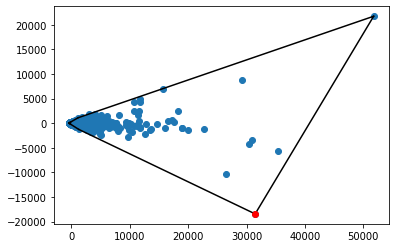

In [25]:
plt.cla()
proj2d = embeddings[:,:2]
hull = ConvexHull(proj2d)
plt.plot(proj2d[:,0], proj2d[:,1], 'o')
for simplex in hull.simplices:
    plt.plot(proj2d[simplex, 0], proj2d[simplex, 1], 'k-')
for vertex in hull.vertices:
    plt.plot(proj2d[vertex,0], proj2d[vertex,1], 'r--', lw=2, label=vocab[vertex])
plt.plot(proj2d[hull.vertices[0],0], proj2d[hull.vertices[0],1], 'ro')
plt.show()
# proj3d = embeddings[:,:3]
# hull = ConvexHull(proj3d)
# vocab[hull.vertices], hull.vertices.shape